# Univariate regression to predict the wind speed field

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

import sys
sys.path.append("../..")

from src.logging_metrics import MetricsLogger
from src.data_loaders import get_wake_dataloaders
import src.plotting as plotting
from src.evaluation import evaluate_model

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [2]:
HIDDEN_LAYERS_UNITS = [50, 250]
ACTIVATION_FUNCTION = nn.ReLU()


class UnivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(UnivariateNN, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        layers.append(
            nn.Linear(layer_units[-1], output_space)
        )  # last layer not activated
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [3]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"../data/{FACTORS_FOLDER}/"
INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR = {"ti": 4, "ct": 4}  # , 'x/D': 4, 'y/D': 4}
train_reduc_factor_string = "training_factors=" + "-".join(
    [f"{k}{v}" for k, v in INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR.items()]
).replace("/", "")
# INPUT_VAR_TO_TRAIN_RANGES = {'ti': [(0.15, 0.4)], 'ct': [(0.3, 0.7)]}
# train_range_string = "training_ranges=" + '-'.join([f"{var}{r[0]}-{r[1]}" for var, ranges in INPUT_VAR_TO_TRAIN_RANGES.items() for r in ranges])
EXPERIMENT = "interpolation"
MODEL_NAME = f"univariate_NN_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}_{train_reduc_factor_string}"
BEST_MODEL_PATH = f"../saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = False
COORDS_AS_INPUT = True  # univariate setting
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = BEST_MODEL_PATH.replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

# hyperparameters
# in univariate, the batch size is a multiplier for number of cells
# (i.e. the batch_size should be dividible by the number of cells)
BATCH_MULTIPLIER = 8
EPOCHS = 160
LR = 1e-2

MODEL_DESCRIPTION = (
    f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} "
    + f"(not last layer), batch multiplier {BATCH_MULTIPLIER}, {EPOCHS} epochs, lr={LR})"
)

print(f"Model description: {MODEL_DESCRIPTION}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

Model name: univariate_NN_layers50-250_training_factors=ti4-ct4
Best model path: saved_models/discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01/univariate_NN_layers50-250_training_factors=ti4-ct4.pt
Model description: univariate_NN_layers50-250_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 160 epochs, lr=0.01)

Device: cpu


In [4]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(
    DATA_FOLDER,
    consider_ws=CONSIDER_WS,
    coords_as_input=COORDS_AS_INPUT,
    # train_perc=0.6,
    # test_perc=0.2,
    # validation_perc=0.2,
    input_var_to_train_reduction_factor=INPUT_VAR_TO_TRAIN_REDUCTION_FACTOR,
    # input_var_to_train_ranges=INPUT_VAR_TO_TRAIN_RANGES,
    batch_multiplier=BATCH_MULTIPLIER,
)
len(train_dataloader), len(test_dataloader)

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/utils/data_loaders.py:328: UserWarning: 
Ignoring percentages of train-valid-test split (train_perc=0.8, valid_perc=0, test_perc=0.2)
and using the reduction factors for the training set instead:
{'ti': 4, 'ct': 4}
  warnings.warn(


(69, 504)

In [5]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([57344, 4]) torch.Size([57344, 1])
input_space=4	output_space=1


In [6]:
model = UnivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=LR)
loss_function = torch.nn.MSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.0
for epoch in range(EPOCHS):
    """TRAINING"""
    model.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model(x)
        tloss = loss_function(prediction, y)
        tloss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item() * x.size(0)
        # TODO accuracy or other metric computation????

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, "Training loss", avg_tloss)

    """VALIDATION"""
    if valid_dataloader:
        model.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(x)
            vloss = loss_function(prediction, y)

            epoch_vloss += vloss.item() * x.size(0)

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, "Validation loss", avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

Logging univariate_NN_layers50-250_training_factors=ti4-ct4-xD4-yD4
Epoch 0 ->	Training loss=0.01055955059611686	Validation loss=0.0007052718522200207	epoch_time (seconds)=122	
Epoch 1 ->	Training loss=0.0005278423162632283	Validation loss=0.0002547417416880344	epoch_time (seconds)=121	
Epoch 2 ->	Training loss=0.00019137303693300906	Validation loss=0.00016997472307896512	epoch_time (seconds)=121	
Epoch 3 ->	Training loss=0.0001053999576115884	Validation loss=0.00014627297265996936	epoch_time (seconds)=121	
Epoch 4 ->	Training loss=7.634655301373712e-05	Validation loss=0.00013174845127474484	epoch_time (seconds)=121	
Epoch 5 ->	Training loss=6.340189140081003e-05	Validation loss=0.0001374442302420881	epoch_time (seconds)=122	
Epoch 6 ->	Training loss=5.614766393012939e-05	Validation loss=0.00012580353487150049	epoch_time (seconds)=122	
Epoch 7 ->	Training loss=5.202016923072001e-05	Validation loss=0.00012361385849859872	epoch_time (seconds)=122	
Epoch 8 ->	Training loss=4.9275213491278

KeyboardInterrupt: 

epoch_time (seconds)=73	

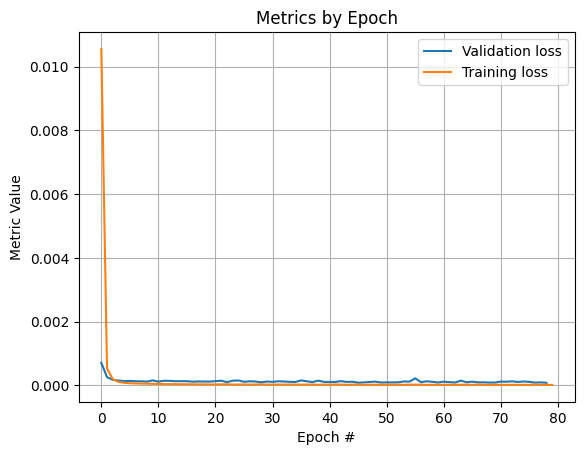

Metrics exported in the following csv file: metrics/logged_metrics/univariate_NN_layers50-250_training_factors=ti4-ct4-xD4-yD4_14-07-2023_08-49-25.csv


In [7]:
metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Evaluation and testing

In [6]:
# loading best model
model = UnivariateNN(input_space, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

save_results = False

# evaluation on trainset
evaluate_model(
    model,
    data=train_dataloader,
    data_type="train",
    model_description=MODEL_DESCRIPTION,
    save_results=save_results,
    experiment=EXPERIMENT,
)

print("\n")

# evalution on testset
evaluate_model(
    model,
    data=test_dataloader,
    data_type="test",
    model_description=MODEL_DESCRIPTION,
    save_results=save_results,
    experiment=EXPERIMENT,
)

Train results for univariate_NN_layers50-250_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 160 epochs, lr=0.01)
metrics/final_results/trainset_results_interpolation.csv
r2_score=0.984466418421802
explained_variance_score=0.984559178352356
mean_squared_error=1.9313418306410313e-05
mean_absolute_error=0.0018736016936600208
median_absolute_error=0.000869865994900465
mean_absolute_percentage_error=95555756032.0
peak_signal_noise_ratio=47.141408530860964
Prediction time=6.607432559422858e-06s


Test results for univariate_NN_layers50-250_training_factors=ti4-ct4_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch multiplier 8, 160 epochs, lr=0.01)
metrics/final_results/testset_results_interpolation.csv
r2_score=0.9846103201951194
explained_variance_score=0.9847199320793152
mean_squared_error=1.7256996216019616e-05
mean_absolute_error=0.001800326746888458

In [17]:
test_dataset = test_dataloader.dataset
num_cells = test_dataset.num_cells
num_fields = len(test_dataset) // num_cells
field_indices = list(range(num_fields))
random.shuffle(field_indices)

with torch.no_grad():
    for field_idx in field_indices[:10]:
        ti, ct, ws, wake_field, predicted_wake_field = (
            test_dataset.get_parameters_for_plotting_univariate(model, field_idx)
        )
        plotting.plot_maps(
            test_dataset.X_grid,
            test_dataset.Y_grid,
            wake_field,
            predicted_wake_field,
            ti,
            ct,
            ws,
            error_to_plot="absolute",
        )